In [293]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import scipy.stats
from datetime import datetime

In [223]:
# os.chdir('C:/Users/voskresensky/Documents/citizen_science/networks')

In [224]:
df = pd.read_csv('CNC_San_Francisco_2017.csv')

In [225]:
df2 = pd.read_csv('CNC_San_Francisco_2018.csv')

In [ ]:
df_net = pd.DataFrame()
    
    for _, row in df.iterrows():
        idents = row['identifications']
        if pd.isnull(idents) == False:
            df_temp = pd.DataFrame(eval(idents))
            df_temp['target'] = np.repeat(row['user_id'], df_temp.shape[0])
            df_net = df_net.append(df_temp)

In [313]:
df_net

,activity_count,category,created_at,disagreement,identifications_count,observations_count,universal_search_rank,user_id,target,Date
0,73032,maverick,2017-04-13T21:12:42+00:00,None,23480,49499,49499,8778,8778,2017-04-13 21:12:42+00:00
1,52298,improving,2018-11-26T15:05:27+00:00,True,32104,20154,20154,275891,8778,2018-11-26 15:05:27+00:00
2,73032,supporting,2018-11-26T16:05:37+00:00,False,23480,49499,49499,8778,8778,2018-11-26 16:05:37+00:00
0,192319,supporting,2018-11-26T13:56:03+00:00,False,162965,29333,29333,179103,4797,2018-11-26 13:56:03+00:00
1,488,improving,2017-04-14T01:37:08+00:00,None,100,388,388,4797,4797,2017-04-14 01:37:08+00:00
0,192319,supporting,2018-11-26T13:56:05+00:00,False,162965,29333,29333,179103,4797,2018-11-26 13:56:05+00:00
1,488,improving,2017-04-14T01:44:41+00:00,None,100,388,388,4797,4797,2017-04-14 01:44:41+00:00
0,133264,None,2017-04-14T07:20:21+00:00,None,92893,40285,40285,1,1,2017-04-14 07:20:21+00:00
0,77418,leading,2017-04-14T00:29:36-07:00,None,23071,54340,54340,3494,3494,2017-04-14 00:29:36-07:00
1,24557,improving,2017-11-19T12:59:46-08:00,None,12672,11878,11878,477431,3494,2017-11-19 12:59:46-08:00


In [317]:
df_net['year'] = pd.to_datetime(df_net['created_at'], utc = True).dt.to_period('M')

In [230]:
def bipartite_net_make(df, min_weight = 2):
    """
    The function returns a biaprtite network with the two types of nodes: observations and 
    actions (changes made by other users of INaturalist)
    
    Arguments:
    - df -- dataframe
    - min_weight - minimal weight of an edge between nodes
    """
    
    df_net = pd.DataFrame()
    
    for _, row in df.iterrows():
        idents = row['identifications']
        if pd.isnull(idents) == False:
            df_temp = pd.DataFrame(eval(idents))
            df_temp['target'] = np.repeat(row['user_id'], df_temp.shape[0])
            df_net = df_net.append(df_temp)
        
    edges = pd.DataFrame(df_net[['user_id', 'target']])
    
    # removing loops
    edges['temp'] = np.array(edges['user_id']) == np.array(edges['target'])
    edges = edges[edges['temp'] == False]
    edges = edges.drop(['temp'], axis = 1)
    
    # removing edges based on the chosen threshold
    edges['weight'] = 1
    edges = edges.groupby(by=['user_id', 'target']).sum().reset_index()
    edges = edges[edges['weight'] >= min_weight]
    
    bipartite_G = nx.Graph()

    for r, d in edges.iterrows():
        pid = 'P{0}'.format(d['user_id']) 
        cid = 'C{0}'.format(d['target'])  
        bipartite_G.add_node(pid, bipartite='action')
        bipartite_G.add_node(cid, bipartite='observation')
        bipartite_G.add_edge(pid, cid)
        
    return bipartite_G

In [237]:
def projection_make(bip_net, projection = 'action'):
    """
    The function returns a projection of a bipartite network 
    
    Arguments:
    
    - bip_net -- bipartite networks
    - projection (observation or action) -- in the case of 'action', the function returns a network where users are
    connected based on the common observations (they were working on); 'observation'  returns a network of 
    observations having a common list of collaborators
    """
    
    if projection == 'action':
        action_nodes = [node for node in bip_net.nodes() if bip_net.nodes[node]['bipartite'] == 'action']
        actions_graph = nx.bipartite.projection.projected_graph(bip_net, action_nodes)
        
        return actions_graph
    
    elif projection == 'observation':
        observation_nodes = [node for node in bip_net.nodes() if bip_net.nodes[node]['bipartite'] == 'observation']
        observations_graph = nx.bipartite.projection.projected_graph(bip_net, observation_nodes)
        
        return observations_graph

In [232]:
g_sf_2017 = bipartite_net_make(df, min_weight = 2)

In [226]:
g_sf_2018 = bipartite_net_make(df2, min_weight = 2)

In [189]:
nx.bipartite.is_bipartite(g_sf_2017)

True

In [227]:
action_nodes = [node for node in bipartite_G.nodes() if bipartite_G.nodes[node]['bipartite'] == 'action']
action_nodes_with_centrality = [node for node in nx.bipartite.degree_centrality(bipartite_G, action_nodes).items() if node[0].startswith("C")]
sorted(action_nodes_with_centrality, key=lambda x: x[1], reverse=True)[:5]

In [240]:
g_sf2017_proj = projection_make(g_sf_2017, projection = 'action')

In [241]:
g_sf2017_proj.number_of_nodes()

492

In [242]:
g_sf2017_proj.number_of_edges()

25783

In [243]:
nx.density(g_sf2017_proj)

0.21346016922491018

In [247]:
g_sf2018_proj = projection_make(g_sf_2018, projection = 'action')

In [248]:
g_sf2018_proj.number_of_nodes()

636

In [249]:
g_sf2018_proj.number_of_edges()

30628

In [250]:
nx.density(g_sf2018_proj)

0.15167632347843313

In [255]:
users_activity = df2.groupby('user_id')['id'].count().reset_index()

In [258]:
action_nodes = [node for node in g_sf_2018.nodes() if g_sf_2018.nodes[node]['bipartite'] == 'action']
action_nodes_with_centrality = [node for node in nx.bipartite.degree_centrality(g_sf_2018, action_nodes).items() if node[0].startswith("P")]

In [261]:
users_centrality = pd.DataFrame(action_nodes_with_centrality, columns=['user_id', 'degree'])

In [265]:
users_centrality['user_id'] = pd.to_numeric(users_centrality['user_id'].str.replace('P', '', regex=False))

In [268]:
activ_centr = pd.merge(users_activity, users_centrality, on = "user_id", how = 'inner')

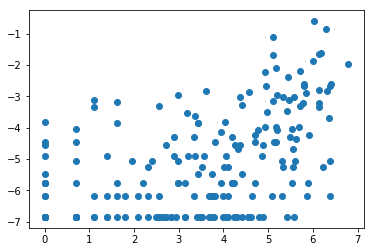

In [278]:
plt.scatter(np.log(activ_centr['id']), np.log(activ_centr['degree']))

In [274]:
scipy.stats.spearmanr(activ_centr['id'], activ_centr['degree'])

SpearmanrResult(correlation=0.5229645587206072, pvalue=6.096186541973602e-15)

In [115]:
from netwulf import visualize

In [252]:
visualize(g_sf2018_proj)

(None, None)

In [ ]:
# correlation activity vs. centrality
# comparison of years
# dynamics of activity